In [10]:
import os
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata and diagnosis
metadata_df = pd.read_csv(r"C:\Shivangi\college\Sem 5\Deep Learning\DL project\greymatter\20_subjects_small_model\merged_mri_metadata.csv")
diagnosis_df = pd.read_csv("F:/DL_DATASET/DXSUM_04Dec2024.csv")

processed_images = np.load("processed_images_zip2.npy")

# Mapping diagnosis to label
diagnosis_map = {1: 'CN', 2: 'MCI', 3: 'AD'}

metadata_df['DIAGNOSIS'] = metadata_df['patient_id'].apply(
    lambda x: diagnosis_df[diagnosis_df['PTID'] == x]['DIAGNOSIS'].values[0]
)

# Label encode DIAGNOSIS
label_encoder = LabelEncoder()
metadata_df['label'] = label_encoder.fit_transform(metadata_df['DIAGNOSIS'])

# Split
train_df, val_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df['label'], random_state=42)

class MRI_Dataset(Dataset):
    def __init__(self, metadata_df, images, transform=None):
        self.metadata_df = metadata_df
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.metadata_df.iloc[idx]['label']
        image = image.astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dataset = MRI_Dataset(train_df, processed_images[train_df.index.values], transform=transform)
val_dataset = MRI_Dataset(val_df, processed_images[val_df.index.values], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

model = models.vgg16(weights='IMAGENET1K_V1')
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 3),
    nn.Softmax(dim=1)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

num_epochs = 4
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    
    model.eval()
    correct_preds = 0
    total_preds = 0
    val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = correct_preds / total_preds
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    

print("Training complete.")


# ----------------------------
# SALIENCY MAP
# ----------------------------
def compute_saliency_map(model, input_tensor, target_class):
    model.eval()
    input_tensor = input_tensor.clone().requires_grad_(True)
    model.zero_grad()
    output = model(input_tensor)
    loss = output[0, target_class]
    loss.backward()
    saliency = input_tensor.grad.data.abs().cpu().numpy().squeeze()
    return saliency

# ----------------------------
# GRAD-CAM
# ----------------------------
# We pick the last convolutional layer from VGG16 for Grad-CAM
target_layer = model.features[-1]  # last layer in features (should be a ReLU or conv)
# Actually, we need a convolutional layer. Let's find the last conv layer:
# VGG16 ends with: features[-2] = ReLU, features[-3] = Conv2d. Let's pick features[28] for example (the last conv layer)
# Original VGG16 last conv layer index: features[28] = conv layer, features[29]=ReLU
conv_layer = model.features[28]

# Store activations and gradients
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

# Register hooks
conv_layer.register_forward_hook(forward_hook)
conv_layer.register_backward_hook(backward_hook)

def compute_gradcam(model, input_tensor, target_class):
    model.eval()
    model.zero_grad()
    output = model(input_tensor)
    loss = output[0, target_class]
    loss.backward()
    
    # gradients: shape (batch, channels, h, w)
    # activations: shape (batch, channels, h, w)
    # We have only one image: batch = 1
    alpha = gradients.mean(dim=[2,3], keepdim=True)  # avg gradient over spatial dims -> (1, channels, 1, 1)
    weighted_activations = (alpha * activations)
    cam = weighted_activations.sum(dim=1).squeeze().cpu().numpy()  # sum over channels -> shape (h, w)

    # ReLU
    cam = np.maximum(cam, 0)

    # Normalize to [0,1]
    cam = cam - cam.min()
    cam = cam / cam.max()
    return cam


# ----------------------------
# Example: Compute saliency and grad-cam for the first val sample
# ----------------------------
model.eval()
val_iterator = iter(val_loader)
sample_inputs, sample_labels = next(val_iterator)
sample_inputs = sample_inputs.to(device)

# Get prediction
with torch.no_grad():
    pred_output = model(sample_inputs)
    predicted_class = pred_output.argmax(dim=1)[0].item()

# Compute saliency map for the first image in this batch
image_to_explain = sample_inputs[0].unsqueeze(0)  # (1,1,224,224)
saliency_map = compute_saliency_map(model, image_to_explain, predicted_class)
print("Saliency map shape:", saliency_map.shape)

# Compute Grad-CAM for the same image and class
gradcam_map = compute_gradcam(model, image_to_explain, predicted_class)
print("Grad-CAM map shape:", gradcam_map.shape)

# Now you have both saliency_map and gradcam_map arrays.
# They can be visualized using matplotlib's imshow to interpret them.


Epoch 1/4: 100%|██████████| 1001/1001 [04:43<00:00,  3.53it/s]


Epoch 1/4 | Train Loss: 0.8056 | Train Acc: 76.47% | Val Loss: 0.7453 | Val Acc: 83.63%


Epoch 2/4: 100%|██████████| 1001/1001 [05:42<00:00,  2.92it/s]


Epoch 2/4 | Train Loss: 0.7427 | Train Acc: 82.32% | Val Loss: 0.7260 | Val Acc: 85.03%


Epoch 3/4: 100%|██████████| 1001/1001 [10:04<00:00,  1.66it/s]


Epoch 3/4 | Train Loss: 0.7294 | Train Acc: 83.22% | Val Loss: 0.7160 | Val Acc: 85.63%


Epoch 4/4: 100%|██████████| 1001/1001 [06:38<00:00,  2.51it/s]


Epoch 4/4 | Train Loss: 0.7249 | Train Acc: 83.67% | Val Loss: 0.7088 | Val Acc: 86.03%
Training complete.


c:\Software\anaconda3\envs\dl_project\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saliency map shape: (224, 224)
Grad-CAM map shape: (14, 14)


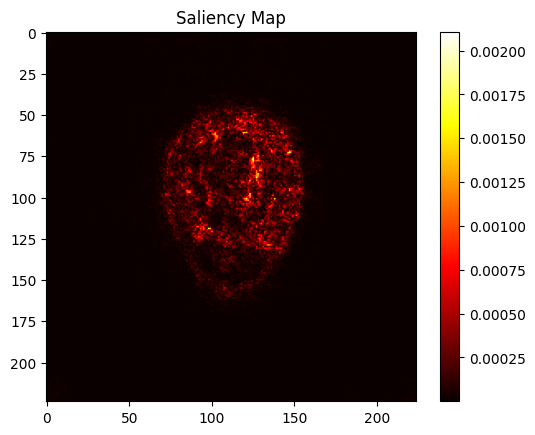

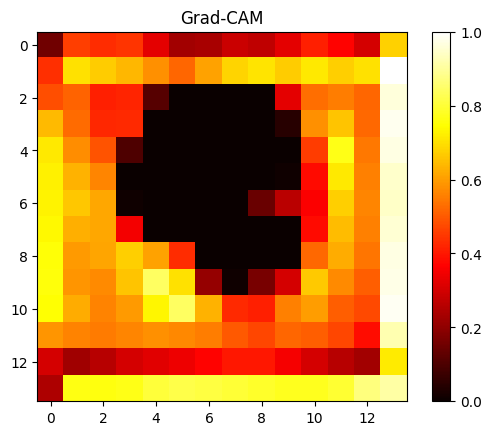

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Grad-CAM")
plt.imshow(gradcam_map, cmap='hot')
plt.colorbar()
plt.show()

In [12]:
# do 2 more epochs on the current model
num_epochs = 2
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    
    model.eval()
    correct_preds = 0
    total_preds = 0
    val_loss = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = correct_preds / total_preds
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
# create saliency map and grad-cam for the first val sample


Epoch 1/2: 100%|██████████| 1001/1001 [05:43<00:00,  2.91it/s]


Epoch 1/2 | Train Loss: 0.7201 | Train Acc: 83.87% | Val Loss: 0.7066 | Val Acc: 85.83%


Epoch 2/2: 100%|██████████| 1001/1001 [06:07<00:00,  2.73it/s]


Epoch 2/2 | Train Loss: 0.7200 | Train Acc: 83.62% | Val Loss: 0.7034 | Val Acc: 85.43%


In [13]:
# Example: Compute saliency and grad-cam for the first val sample
# ----------------------------
model.eval()
val_iterator = iter(val_loader)
sample_inputs, sample_labels = next(val_iterator)
sample_inputs = sample_inputs.to(device)

# Get prediction
with torch.no_grad():
    pred_output = model(sample_inputs)
    predicted_class = pred_output.argmax(dim=1)[0].item()

# Compute saliency map for the first image in this batch
image_to_explain = sample_inputs[0].unsqueeze(0)  # (1,1,224,224)
saliency_map = compute_saliency_map(model, image_to_explain, predicted_class)
print("Saliency map shape:", saliency_map.shape)

# Compute Grad-CAM for the same image and class
gradcam_map = compute_gradcam(model, image_to_explain, predicted_class)
print("Grad-CAM map shape:", gradcam_map.shape)

Saliency map shape: (224, 224)
Grad-CAM map shape: (14, 14)
